In [1]:
# importing required libraries, functions

import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
from math import pi, sqrt, exp
from pprint import pprint
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# preprocessing data

df = pd.read_csv('Train_F.csv')

le = LabelEncoder()
df['statename'] = le.fit_transform(df['statename'])
df['countyname'] = le.fit_transform(df['countyname'])

remove_cols = ['countyfips']
df = df.drop(columns=remove_cols)

In [3]:
# train test split

df_train = df.sample(frac=0.8)
df_test = df.drop(df_train.index)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [4]:
# find P(h) for all possible h

def get_class_prob(df):
    total = df['severity_county_5-day'].size
    class_values = df['severity_county_5-day'].value_counts()
    class_probs = dict()
    for label in df['severity_county_5-day'].unique():
        class_probs[label] = class_values[label]/total
    return class_probs

# separate training data for different h

def separate_classes(df):
    separate = dict()
    for label in df['severity_county_5-day'].unique():
        separate[label] = df[df['severity_county_5-day']==label]
    return separate

# find the probability from given pdf or pmf

def calculate_probability(x, typ, pdf=None, pmf=None):
    if(typ=='continuous'):
        mean = pdf['mean']
        stddev = pdf['stddev']
        exponent = exp(-0.5 * ((x-mean)/stddev)**2)
        return exponent / (sqrt(2*pi)*stddev)
    else:
        if x not in pmf.keys():
            return 1 / (pmf['total']+1)
        return pmf[x]
    
# get the pmf for discrete variable
    
def get_pmf(df, rows, col):
    pmf = dict()
    total = rows[col].size+len(df[col].unique())
    for val in df[col].unique().tolist():
        pmf[val] = (rows[col][rows[col]==val].size+1) / total
    pmf['total'] = rows[col].size
    
    return pmf

# define the Naive Bayes model using the training data

def get_model(df):
    model = dict()
    separate = separate_classes(df)
    class_prob = get_class_prob(df)
    for label, rows in separate.items():
        model[label] = dict()
        for col in df.columns[:-1]:
            model[label][col] = dict()
            if(col == 'statename' or col == 'countyname'):
                model[label][col] = get_pmf(df, rows, col)
            else:
                model[label][col]['mean'] = rows[col].mean()
                model[label][col]['stddev'] = rows[col].std()
        model[label]['prob'] = class_prob[label]
        
    return model

# predict the hypothesis for given test set using Naive Bayes model

def predict(model, df_test):
    
    predictions = []
    for index, row in df_test.iterrows():
        final_label, max_prob = None, 0
        for label in model.keys():
            probability = model[label]['prob']
            for col in df_test.columns[:-1]:
                if(col == 'statename' or col == 'countyname'):
                    probability *= calculate_probability(x=row[col], pmf=model[label][col], typ='discrete')
                else:
                    probability *= calculate_probability(x=row[col], pdf=model[label][col], typ='continuous')
            if(probability > max_prob):
                max_prob = probability
                final_label = label
        predictions.append(final_label)
    
    return predictions

# find accuracy of predictions

def find_accuracy(df_test, predictions):
    return np.sum(df_test['severity_county_5-day'] == predictions)/df_test['severity_county_5-day'].size

# perform k fold cross validation using Naive Bayes

def k_fold_cross_validation(df_train, k=5):
    scores = []
    split = np.array_split(df_train, 5)
    for i in range(k):
        frames = []
        for j in range(k):
            if(i==j):
                continue
            frames.append(split[j])
        train = pd.concat(frames)
        train = train.reset_index(drop=True)
        test = split[i].reset_index(drop=True)
        model = get_model(train)
        predictions = predict(model, test)
        scores.append(find_accuracy(test, predictions))
    return scores, np.mean(scores)

# get the PCA object for performing transform on training and testing data

def pca_transform(df):
    df_data = df.drop(columns=['severity_county_5-day'])
    pca = PCA()
    pca.fit(df_data)
    variance_cumsum = np.cumsum(pca.explained_variance_ratio_)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x = range(len(pca.explained_variance_ratio_)), height = pca.explained_variance_ratio_)
    ax.set_xlabel('PCA Components')
    ax.set_ylabel('Explained Variance Ratio')
    plt.show()
    pca = PCA(n_components=2)
    pca.fit(df_data)
    return pca

# transform the training and test data

def transform(df_train, df_test):
    pca = pca_transform(df_train)
    df_train_data = df_train.drop(columns=['severity_county_5-day'])
    df_train_transform = pd.DataFrame(data=pca.transform(df_train_data), columns=['PCA%i'%i for i in range(pca.n_components_)])
    df_train_transform['severity_county_5-day'] = df_train['severity_county_5-day']
    df_test_data = df_test.drop(columns=['severity_county_5-day'])
    df_test_transform = pd.DataFrame(data=pca.transform(df_test_data), columns=['PCA%i'%i for i in range(pca.n_components_)])
    df_test_transform['severity_county_5-day'] = df_test['severity_county_5-day']
    return df_train_transform, df_test_transform

# remove the outliers from training data

def remove_outliers(df):
    key_mean_std = dict()
    for col in df.columns[:-1]:
        key_mean_std[col] = dict()
        key_mean_std[col]['mean'] = df[col].mean()
        key_mean_std[col]['stddev'] = df[col].std()
    
    outliers_dict = dict()
    max_outliers = 0
    for x in range(len(df.columns[:-1])+1):
        outliers_dict[x] = []
    for index, row in df.iterrows():
        outliers = 0
        for col in df.columns[:-1]:
            if((row[col] < key_mean_std[col]['mean'] - 3 * key_mean_std[col]['stddev']) or (row[col] > key_mean_std[col]['mean'] + 3 * key_mean_std[col]['stddev'])):
                outliers += 1
        outliers_dict[outliers].append(index)
        if(outliers > max_outliers):
            max_outliers = outliers
            
    return df.drop(index = outliers_dict[max_outliers]).reset_index(drop=True)

# perform sequential backward selection using Naive Bayes

def seq_backward_selection(df_train, df_val):
    columns = df_train.columns[:-1]
    model = get_model(df_train)
    predictions = predict(model, df_val)
    orig_acc = find_accuracy(df_val, predictions)
    max_acc = 0
    remove_cols = []
    col_t = None
    for col in columns:
        df_t = df_train.drop(columns=[col])
        model = get_model(df_t)
        predictions = predict(model, df_val.drop(columns=[col]))
        acc_t = find_accuracy(df_val.drop(columns=[col]), predictions)
        if(acc_t > max_acc):
            max_acc = acc_t
            col_t = col
        
    if(max_acc > orig_acc):
        remove_cols.append(col_t)
        remove_cols.extend(seq_backward_selection(df_train.drop(columns=remove_cols), df_val.drop(columns=remove_cols)))
    return remove_cols

In [5]:
# perform k fold CV for Naive Bayes on preprocessed data

scores, avg = k_fold_cross_validation(df_train)
print(scores, avg)

[0.4552683896620278, 0.44731610337972166, 0.43141153081510936, 0.49502982107355864, 0.43824701195219123] 0.45345457137652173


In [6]:
# final testing accuracy

model = get_model(df_train)
predictions = predict(model, df_test)
find_accuracy(df_test, predictions)

0.4426751592356688

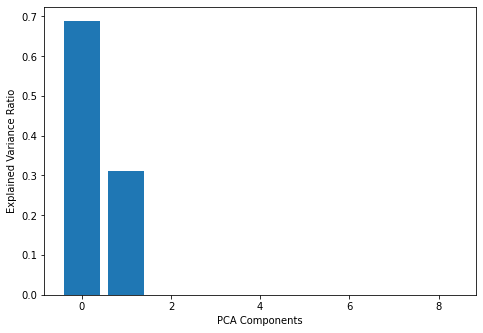

In [7]:
# transform training and testing data

df_train_pca, df_test_pca = transform(df_train, df_test)

Text(0, 0.5, 'PCA1')

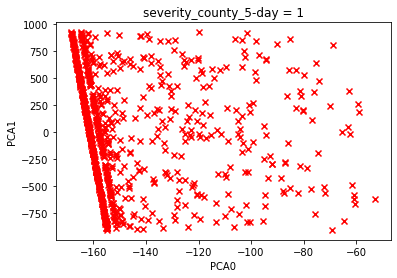

In [8]:
# PCA applied data for label = 1

plt.scatter(x = df_train_pca['PCA0'][df_train_pca['severity_county_5-day']==1], y = df_train_pca['PCA1'][df_train_pca['severity_county_5-day']==1], c='r', marker='x')
plt.title('severity_county_5-day = 1')
plt.xlabel('PCA0')
plt.ylabel('PCA1')

Text(0, 0.5, 'PCA1')

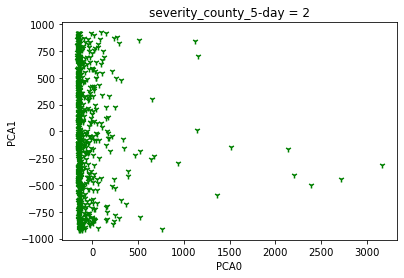

In [9]:
# PCA applied data for label = 2

plt.scatter(x = df_train_pca['PCA0'][df_train_pca['severity_county_5-day']==2], y = df_train_pca['PCA1'][df_train_pca['severity_county_5-day']==2], c='g', marker='1')
plt.title('severity_county_5-day = 2')
plt.xlabel('PCA0')
plt.ylabel('PCA1')

Text(0, 0.5, 'PCA1')

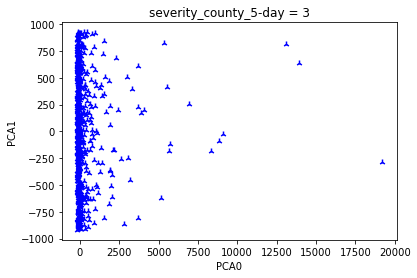

In [10]:
# PCA applied data for label = 3

plt.scatter(x = df_train_pca['PCA0'][df_train_pca['severity_county_5-day']==3], y = df_train_pca['PCA1'][df_train_pca['severity_county_5-day']==3], c='b', marker='2')
plt.title('severity_county_5-day = 3')
plt.xlabel('PCA0')
plt.ylabel('PCA1')

In [11]:
# perform k fold CV for Naive Bayes on data after applying PCA

scores, avg = k_fold_cross_validation(df_train_pca)
print(scores, avg)

[0.46123260437375746, 0.4532803180914513, 0.4294234592445328, 0.49502982107355864, 0.4402390438247012] 0.45584104932160024


In [12]:
# final test accuracy on PCA applied data

model = get_model(df_train_pca)
predictions = predict(model, df_test_pca)
print(find_accuracy(df_test_pca, predictions))

0.4426751592356688


In [13]:
# remove outliers, perform sequential backward selection on train and test data

df_train_drop = remove_outliers(df_train)
remove_cols = seq_backward_selection(df_train_drop, df_test)
df_train_sbs = df_train_drop.drop(columns=remove_cols)
df_test_sbs = df_test.drop(columns=remove_cols)
print(df_train_sbs.columns[:-1])

Index(['predicted_deaths_by_october_06', 'predicted_deaths_by_october_07',
       'predicted_deaths_by_october_08', 'predicted_deaths_by_october_09',
       'predicted_deaths_by_october_10', 'predicted_deaths_by_october_11',
       'predicted_deaths_by_october_12'],
      dtype='object')


In [14]:
# perform k fold CV for Naive Bayes on data after applying sequential backward selection

scores, avg = k_fold_cross_validation(df_train_sbs)
print(scores, avg)

[0.45582329317269077, 0.45582329317269077, 0.4245472837022133, 0.5030181086519114, 0.4507042253521127] 0.4579832408103238


In [15]:
# final test accuracy on sequential backward selection applied data

model = get_model(df_train_sbs)
predictions = predict(model, df_test_sbs)
print(find_accuracy(df_test_sbs, predictions))

0.445859872611465
